# Copyright

<PRE>
Jelen Jupyter notebook a Budapesti Műszaki és Gazdaságtudományi Egyetemen tartott "Deep Learning a gyakorlatban Python és LUA alapon" tantárgy segédanyagaként készült. 
A tantárgy honlapja: http://smartlab.tmit.bme.hu/oktatas-deep-learning
Deep Learning kutatás: http://smartlab.tmit.bme.hu/deep-learning

A notebook bármely részének újra felhasználása, publikálása csak a szerzők írásos beleegyezése esetén megegengedett.

2019 (c) Gyires-Tóth Bálint (toth.b kukac tmit pont bme pont hu)
</PRE>

# Konvolúciós neurális hálózatok - alapok
Jelen notebookban a konvolúciós hálók használatának alapjaival ismerkedünk meg. Az itteni példa publikusan elérhető kép adatbázisok két dimenziós konvolúciós hálózattal történő feldolgozásáról fog szólni. Fontos megjegyezni, hogy ahogy a konvolúciós hálók felhasználása ma már sokkal bővebb, mint pusztán képfelismerés, szinte bármilyen tématerületen sikeresen alkalmazzák (pl. beszéd, hang, idősorok, játék botok, stb.).

Az első példánkban Yann LeCunn professzor MNIST kézzel írott szám adatbázisát fogjuk betanítani a hálóval. Az adatbázis elérhető publikusan: http://yann.lecun.com/exdb/mnist/
Illetve szinte mindegyik nagyobb deep learning frameworkben be lehet tölteni parancssorból. A mostani példában előbb a Keras-t fogjuk használni, majd a Tensorflow 2.0 Keras interfészét. Az adatokat is a Keras-on keresztül töltjük be:

In [0]:
from keras.datasets import mnist
from keras.utils import np_utils

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [0]:
x_train = x_train / 255
x_test = x_test / 255

x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")

y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

batch_size=128

A tanítás előtt kapcsoljuk be a GPU-t Colab alatt (Runtime/Change runtime type). Ezután létrehozunk egy egyszerű modellt softmax aktivációs függvénnyel és betanítjuk batch_size batch mérettel:

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.optimizers import SGD

model = Sequential() 
model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=(28,28,1,))) 
model.add(Conv2D(64, (5, 5), activation='relu')) 
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax')) 

print(model.summary())


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 20, 20, 64)        51264     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               819328    
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)              

In [0]:
# Early stopping, amellyel figyeljük a validációs hibát (alap beállítás)
from keras.callbacks import EarlyStopping
patience=10
early_stopping=EarlyStopping(patience=patience, verbose=1)
# Szintén a validációs hibát figyeljük, és elmentjük a legjobb modellt
from keras.callbacks import ModelCheckpoint
checkpointer=ModelCheckpoint(filepath='model.hdf5', save_best_only=True, verbose=1)

In [21]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

network_history = model.fit(x_train, y_train, batch_size=128, epochs=30, verbose=1, validation_split=0.2, callbacks=[early_stopping, checkpointer])

Train on 48000 samples, validate on 12000 samples
Epoch 1/30
48000/48000 [==============================] - 7s 149us/step - loss: 0.0841 - acc: 0.9752 - val_loss: 0.0447 - val_acc: 0.9881

Epoch 00001: val_loss improved from inf to 0.04465, saving model to model.hdf5
Epoch 2/30
48000/48000 [==============================] - 6s 135us/step - loss: 0.0609 - acc: 0.9817 - val_loss: 0.0349 - val_acc: 0.9897

Epoch 00002: val_loss improved from 0.04465 to 0.03494, saving model to model.hdf5
Epoch 3/30
48000/48000 [==============================] - 6s 135us/step - loss: 0.0463 - acc: 0.9856 - val_loss: 0.0356 - val_acc: 0.9899

Epoch 00003: val_loss did not improve from 0.03494
Epoch 4/30
48000/48000 [==============================] - 6s 135us/step - loss: 0.0403 - acc: 0.9876 - val_loss: 0.0309 - val_acc: 0.9915

Epoch 00004: val_loss improved from 0.03494 to 0.03092, saving model to model.hdf5
Epoch 5/30
48000/48000 [==============================] - 7s 146us/step - loss: 0.0326 - acc: 0.98

Ezután visszatöltjük a legjobb modellt és teszteljük:

In [23]:
from keras.models import load_model
model = load_model("model.hdf5")
test_err = model.evaluate(x_test,y_test)
print("Teszt hiba:", test_err[0], "Teszt pontosság:", test_err[1])

10000/10000 [==============================] - 1s 124us/step
Teszt hiba: 0.02171484462986873 Teszt pontosság: 0.9922


## Metrikák, konfúziós (tévesztési) mátrix
Nézzük először, hogy hogyan tudjuk kiszámolni az osztályozáshoz tartozó legfontosabb metrikákat és hogyan tudjuk megjeleníteni a konfúziós mátrixot:

In [24]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, confusion_matrix
# először is nyerjük ki a predikciókat (valószínüség és hozzá tartozó pontosságot)
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred,1)
y_true = np.argmax(y_test,1)

print("test accuracy: %g" %(accuracy_score(y_true, y_pred)))
print("Precision", precision_score(y_true, y_pred, average="macro"))
print("Recall", recall_score(y_true, y_pred, average="macro"))
print("f1_score", f1_score(y_true, y_pred, average="macro"))
print("\nKonfúziós mátrix: ")
conf=confusion_matrix(y_true, y_pred)
print(conf)

test accuracy: 0.9922
Precision 0.9921779567265124
Recall 0.9921531577685421
f1_score 0.9921563449227545

Konfúziós mátrix: 
[[ 975    1    1    0    0    0    1    1    1    0]
 [   0 1131    1    3    0    0    0    0    0    0]
 [   1    1 1026    0    0    0    0    4    0    0]
 [   0    0    4 1003    0    3    0    0    0    0]
 [   0    0    0    0  977    0    0    0    1    4]
 [   0    0    0    4    0  886    1    1    0    0]
 [   5    2    1    0    2    3  945    0    0    0]
 [   0    3    4    1    0    0    0 1018    1    1]
 [   1    0    0    1    0    0    0    1  969    2]
 [   0    2    0    0    5    8    0    1    1  992]]


A tévesztési mátrixot vizuálisan is érdemes vizsgálni:

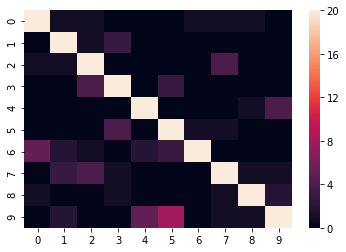

In [27]:
import seaborn as sns
sns.heatmap(conf, vmax=20) # a vmax paraméterrel állítjuk be, hogy milyen értéktartományban jelenítse meg az adatokat

Fontos felhívni a figyelmet a precision, recall és f1 esetén az "avarage" paraméterre. Mivel ezek a metrikák alapvetően két osztályt vesznek figyelembe, ezért több lehetőségünk van több osztálynál az értékek figyelembe vételére. Ennek talán legegyszerűbb módja a "macro", amikor minden osztálynál kiszámolt érték átlagát veszi. Ha "micro"-ra állítjuk, akkor összegzi az összes osztály esetén a TP, TN, FN, FP értékeket és ezekkel számol. "weighted" esetben pedig azt is figyelembe veszi, hogy melyik osztályban mennyi minta van, és amelyikbe sok, azt nagyobb súllyal veszi figyelembe. 

## TensorFlow 2.0

Lentebb található egy általános, az alap Keras-nál alacsonyabb szintű tanítási struktúra TensorFlow 2.0 alatt. Mint láthatjuk, bonyolultabb, azonban a különböző egységeken keresztül nagyobb kontrollunk van a teljes tanítási folyamat felett. Természetesen ebben az egyszerű példában erre nincs feltétlen szükségünk, de összetettebb tanítások esetén a flexibilitás sokat segíthet. 

In [0]:
# eager exection bekapcsolása, bővebb információ: https://www.tensorflow.org/guide/eager
# a kernel-t (Colab alatt a runtime-ot) újra kell indítani, és innen lehet utána folytatni a kódrészek futtatását
import tensorflow as tf
import tensorflow.contrib.eager as tfe

tf.enable_eager_execution()

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

(x, y), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x = x.astype("float32")
x_test = x_test.astype("float32")

Adatok előkészítése:

In [0]:
# A szín csatorna hozzáadása
x_train = x[:50000, ..., tf.newaxis]
y_train = y[:50000]
x_valid = x[50000:, ..., tf.newaxis]
y_valid = y[50000:]
x_test = x_test[..., tf.newaxis]

# Adatok előkészítése és összekeverése
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(128)
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(128)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(128)

A tanítás előtt kapcsoljuk be a GPU-t Colab alatt (Runtime/Change runtime type). Ezután létrehozunk egy egyszerű osztályozó modellt softmax aktivációs függvénnyel:

In [0]:
class MNIST_model(Model):
    def __init__(self):
        super(MNIST_model, self).__init__()
        self.conv1 = Conv2D(32, 5, activation='relu')
        self.conv2 = Conv2D(64, 5, activation='relu')
        self.flatten = Flatten()
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(10, activation='softmax')

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)

model = MNIST_model()

Ezután definiáljuk az optimizáló algoritmust és a hibafüggvényt:

In [0]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

Majd adjuk meg a metrikákat, amiket figyelni szeretnénk a tanítás során:


In [0]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

valid_loss = tf.keras.metrics.Mean(name='valid_loss')
valid_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='valid_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

Majd adjuk meg a tanító, validációs és tesztelő függvényeinket. A @tf.function adja meg, hogy a kifejezést követő függvényt "natív" TensorFlow függvényként kezelje a TensorFlow, tehát pl. a számítási gráf paramétereit vagy a gradienseket el tudjuk belőle érni.

In [0]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)
    
@tf.function
def valid_step(images, labels):
    predictions = model(images)
    v_loss = loss_object(labels, predictions)

    valid_loss(v_loss)
    valid_accuracy(labels, predictions)    
    
    
@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)    



Végül hívjuk meg a tanítást végző ciklusunkat. 

In [8]:
EPOCHS     = 50000
patience   = 10
min_err    = 99999
es_counter = 0

for epoch in range(EPOCHS):
    for images, labels in train_ds:
        train_step(images, labels)
    for valid_images, valid_labels in valid_ds:
        valid_step(valid_images, valid_labels)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Valid Loss: {}, Valid Accuracy: {}'
    print(template.format(epoch+1, train_loss.result(), train_accuracy.result()*100,valid_loss.result(),valid_accuracy.result()*100))

    if valid_loss.result().numpy()<min_err:
        min_err = valid_loss.result().numpy()
        es_counter = 0
        model.save_weights("weights.hdf5")
    else:
        es_counter += 1
        
    if es_counter>patience:
        print("Early stopping")
        model.load_weights("weights.hdf5")
        break
    
    # Reseteljük a metrikákat a következő epoch számára
    train_loss.reset_states()
    train_accuracy.reset_states()
    valid_loss.reset_states()
    valid_accuracy.reset_states()

Epoch 1, Loss: 1.3494011163711548, Accuracy: 90.86000061035156, Valid Loss: 0.07824502140283585, Valid Accuracy: 97.6199951171875
Epoch 2, Loss: 0.05609548091888428, Accuracy: 98.31600189208984, Valid Loss: 0.06790241599082947, Valid Accuracy: 97.89999389648438
Epoch 3, Loss: 0.032350439578294754, Accuracy: 98.97200012207031, Valid Loss: 0.07992609590291977, Valid Accuracy: 97.77999877929688
Epoch 4, Loss: 0.023068318143486977, Accuracy: 99.20800018310547, Valid Loss: 0.06837540864944458, Valid Accuracy: 98.23999786376953
Epoch 5, Loss: 0.02365451119840145, Accuracy: 99.26799774169922, Valid Loss: 0.07384598255157471, Valid Accuracy: 98.33999633789062
Epoch 6, Loss: 0.01867353543639183, Accuracy: 99.40399932861328, Valid Loss: 0.1125040054321289, Valid Accuracy: 97.72999572753906
Epoch 7, Loss: 0.016766905784606934, Accuracy: 99.48600006103516, Valid Loss: 0.10675708204507828, Valid Accuracy: 97.98999786376953
Epoch 8, Loss: 0.014837495051324368, Accuracy: 99.5320053100586, Valid Loss:

Ha megvan a betanított modellünk, akkor utána megnézzük, hogy hogyan teljesít a teszt képekre (amik nem voltak benne a tanító adatbázisban:

In [9]:
for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)
template = 'Test Loss: {}, Test Accuracy: {}'
print(template.format(test_loss.result(),test_accuracy.result()*100))


Test Loss: 0.06800329685211182, Test Accuracy: 97.58999633789062
